# Variational Quantum Eigensolver Implemented on a 1D Quantum Harmonic Oscillator
***
## Table of Contents
1. [Introduction](#VQE0)
2. [Hamiltonian Construction](#VQE1)
    1. ["Ignore Me"](#subparagraph1)
3. [Hamiltonian Decomposition](#VQE2)
4. [Ansatz State and Preparation](#VQE3)
5. [Measurement and Optimization](#VQE4)
6. [Sample Runs](#VQE5)
7. [Main References](#Bibliography)

## Introduction <a name="VQE0"></a>
Some introduction text, formatted in heading 2 style

## Hamiltonian Construction <a name="VQE1"></a>
The first paragraph tex

### To delete <a name="subparagraph1"></a>
This is a sub paragraph, formatted in heading 3 style

## Hamiltonian Decomposition <a name="VQE2"></a>
The second paragraph text

## Ansatz State and Preparation <a name = "VQE3"></a>

## Measurement and Optimization <a name = "VQE4"></a>

## Sample Runs <a name = "VQE5"></a>

## Main Referenceces <a name = "Bibliography">

In [3]:
import numpy as np

#mapping for lattice indices
def ell(a,n):
    return (2*a - 1 - n)/2

#discrete fourier transform
def DFT(n):
    F = []
    for j in range(1,n+1):
        F_row = []
        for k in range(1,n+1):
            F_row.append( (1/np.sqrt(n)) * np.exp( (2*np.pi*1j*ell(j,n)*ell(k,n) )/n ) )
        F.append(F_row)
    F = np.matrix(np.round(F,10))
    return F

#position operator
def X_pos(n):
    X = []
    for j in range(1,n+1):
        X_row = []
        for k in range(1,n+1):
            if j==k:
                 X_row.append(np.sqrt(2*np.pi/n)*ell(j,n))
            else:
                X_row.append(0)
        X.append(X_row)
    X = np.matrix(np.round(X,10))
    return X

#momentum operator
def P_pos(n):
    F = DFT(n)
    X_op = X_pos(n)
    F_dag = F.H
    P = np.round((F_dag*X_op*F),10)
    return P

#annihilation operator    
def Aminus(n):
    A = []
    for j in range(1,n+1):
        A_row = []
        for k in range(1, n + 1):
            if j == (k-1):
                A_row.append(np.sqrt(j))
            else:
                A_row.append(0)
        A.append(A_row)
    A = np.matrix(A)
    return A

#creation operator
def Aplus(n):
    A = []
    for j in range(1,n+1):
        A_row = []
        for k in range(1, n + 1):
            if j == (k+1):
                A_row.append(np.sqrt(k))
            else:
                A_row.append(0)
        A.append(A_row)
    A = np.matrix(A)
    return A

In [4]:
#QHO hamiltonian written in terms of position and momentum operators
def QHO(n,basis):
    if basis == 'pos':
        X_op = X_pos(n)
        P_op = P_pos(n)
        H = (X_op*X_op)/2 + (P_op*P_op)/2
        return H
    elif basis == 'en':
        A_dag = Aminus(n)
        A_undag = Aplus(n)
        H = (A_dag*A_undag) + np.identity(n)/2
        return H

In [52]:
import matplotlib.pyplot as plt
def exactE(n):
    E = []
    for i in range(0,n):
        E.append(i+1/2)
    return E

def compareSpect(n):
    H_pos = QHO(n,'pos')
    H_en = QHO(n,'en')
    e_pos, v_pos = np.linalg.eig(H_pos)
    #Prints ground state energy
    print(np.sort(e_pos)[0])
    e_en, v_en = np.linalg.eig(H_en)      
    
    E = exactE(n)  
    nthvalues = np.arange(1,n+1,1)
    
    plt.rcParams["font.family"] = "Times New Roman"
    
    fig, ax = plt.subplots(1,1,figsize = (6,5))
    ax.plot(nthvalues, np.sort(e_pos), label = "position basis")
    ax.plot(nthvalues, np.sort(e_en), label = "energy basis")
    ax.plot(nthvalues, E, label = "exact")
    ax.set_xlabel("n")
    ax.set_ylabel("Energy")
    ax.legend()    

(0.51226883251614+0j)


C:\Users\johns\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


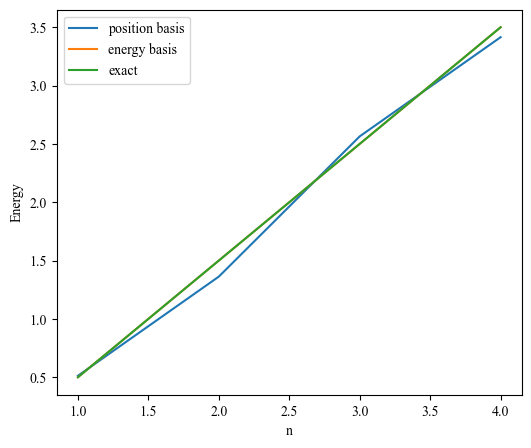

In [53]:
compareSpect(4)
#plt.savefig("Hcomparisons")

In [19]:
def h2zixy(hamiltonian):
    import itertools
    import numpy as np
    
    eps = 1.e-5
    dim = len(hamiltonian)
    
    NextPowTwo = int(2**np.ceil(np.log(dim)/np.log(2)))
    if NextPowTwo != dim:
        diff = NextPowTwo - dim
        hamiltonian = np.hstack((hamiltonian, np.zeros((dim,diff))))
        dim = NextPowTwo
        hamiltonian = np.vstack((hamiltonian, np.zeros((diff,dim))))
    
    Pauli = {'I' : np.array([[1,0],[0,1]]),
             'X' : np.array([[0,1],[1,0]]),
             'Y' : np.array([[0,-1j],[1j,0]]),
             'Z' : np.array([[1,0],[0,-1]])}
    NumTensorRepetitions = int(np.log(dim)/np.log(2))
    NumTotalTensors = 4**NumTensorRepetitions
    PauliKeyList = []
    KeysToDelete = []
    PauliDict = {}
    
    def PauliDictValues(l):
        #returns a generator object, such that calling again yields the next object
        yield from itertools.product(*([l]*NumTensorRepetitions))
    
    for x in PauliDictValues('IXYZ'):
        PauliKeyList.append(''.join(x))
    
    for y in PauliKeyList:
        PauliDict[y] = 0
        
    for key in PauliDict:
        TempList = []
        PauliTensors = []
        NumYs = key.count('Y')
        TempKey = str(key)
    
        if (NumYs % 2) == 0:
            for string in TempKey:
                TempList.append(string)
            
            for SpinMatrix in TempList:
                PauliTensors.append(Pauli[SpinMatrix])
            
            PauliDict[key] = PauliTensors
            CurrentMatrix = PauliDict[key].copy()
        
            for k in range(1, NumTensorRepetitions):
                TemporaryDict = np.kron(CurrentMatrix[k-1], CurrentMatrix[k])
                CurrentMatrix[k] = TemporaryDict
        
            PauliDict[key] = CurrentMatrix[-1]
        
        else:
            KeysToDelete.append(key)
    
    for val in KeysToDelete:
        PauliDict.pop(val)
    
    VecHamElements = np.zeros(int((dim**2+dim)/2))
    h=0
    for i in range (0,dim):
        for j in range(i,dim):
            arr = []
            VecHamElements[h] = hamiltonian[i,j]
            for key in PauliDict:
                TempVar = PauliDict[key]
                arr.append(TempVar[i,j].real)
                
            if i == 0 and j == 0:
                FinalMat = np.array(arr.copy())
            
            else:
                FinalMat = np.vstack((FinalMat,arr))
            
            h += 1
    
    x = np.linalg.solve(FinalMat,VecHamElements)
    a = []
    var_list = list(PauliDict.keys())
    
    DecHam = {}
    for i in range(len(PauliDict)):
        b = x[i]
        if abs(b)>eps:
            DecHam[str(var_list[i])] = np.round(b,4)
            
    return DecHam

In [51]:
h2zixy(QHO(4,'pos'))

C:\Users\johns\AppData\Local\Temp\ipykernel_19172\4022643438.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  VecHamElements[h] = hamiltonian[i,j]


{'II': 1.9635, 'IX': -0.5554, 'YY': -0.5554, 'ZZ': 0.7854}

### VI. Running the VQE



In [118]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, BasicAer, execute
from qiskit.extensions.simulator import snapshot
from qiskit.tools.visualization import circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
import math as m
import scipy as sci
import random
from itertools import permutations
import time

#local simulator
M_simulator = BasicAer.get_backend('qasm_simulator')

#cloud simulator
#service = QiskitRuntimeService()
#M_simulator = service.backend("ibmq_qasm_simulator")

#cloud real quantum computer
#service = QiskitRuntimeService()
#M_simulator = service.backend("ibm_kyoto")


def Measurement(quantumcircuit, **kwargs):
    '''
    Executes a measurement(s) of a QuantumCircuit object for tidier printing
    Keyword Arguments:
    shots (integer) - number of trials to execute for the measurement(s)
    return_M (Bool) - indicates whether to return the Dictionary object containing measurement
    print_M (Bool) - indicates whether to print the measurement results
    column (Bool) - prints each state in a vertical column
    '''
    S=1
    ret = False
    NL = False
    if 'shots' in kwargs:
        S = int(kwargs['shots'])
    if 'return_M' in kwargs:
        ret = kwargs['return_M']
    if 'column' in kwargs:
        NL = kwargs['column']
    M1 = execute(quantumcircuit, M_simulator, shots=S).result().get_counts(quantumcircuit)
    M2 = {}
    k1 = list(M1.keys())
    v1 = list(M1.values())
    for k in np.arange(len(k1)):
        key_list = list(k1[k])
        new_key = ''
        for j in np.arange(len(key_list)):
            new_key = new_key+key_list[len(key_list)-(j+1)]
        M2[new_key] = v1[k]
    if(ret):
        return M2   
    

    
def Single_Qubit_Ansatz( qc, qubit, params ):
    '''
    Input:
    qc (QuantumCircuit)
    qubit (QuantumRegister[i])
    params (array)
    Applies the neccessary rotation gates for a single qubit ansatz state
    '''
    qc.ry( params[0], qubit )
    qc.rz( params[1], qubit )    
    
def Two_Qubit_HEA(qc, q, params):
    '''
    Input:
    qc (QuantumCircuit)
    q (QuantumRegister)
    params (array)
    Creates a 2-Qubit HEA Ansatz
    '''
    qc.ry(params[0], 0)
    qc.rz(params[1], 0)
    qc.ry(params[2], 1)
    qc.rz(params[3], 1)
    qc.cx(0,1)
    qc.ry(params[4], 0)
    qc.rz(params[5], 0)
    qc.ry(params[6], 1)
    qc.rz(params[7], 1)

def Two_Qubit_UniversalAnsatz(qc, q, params):
    '''
    Input:
    qc (QuantumCircuit)
    q (QuantumRegister)
    params (array)
    Creates a 2 qubit universal Ansatz
    '''
    qc.ry(params[0], 0)
    qc.rz(params[1], 0)
    qc.ry(params[2], 1)
    qc.rz(params[3], 1)
    qc.cx(0,1)
    qc.ry(params[4], 0)
    qc.rz(params[5], 0)
    qc.ry(params[6], 1)
    qc.rz(params[7], 1)
    qc.cx(1,0)
    qc.ry(params[8], 0)
    qc.rz(params[9], 0)
    qc.ry(params[10], 1)
    qc.rz(params[11], 1)
    qc.cx(0,1)
    qc.ry(params[12], 0)
    qc.rz(params[13], 0)
    qc.ry(params[14], 1)
    qc.rz(params[15], 1)
    
def Four_Qubit_HEA(qc, q, params):
    '''
    Input:
    qc (QuantumCircuit)
    q (QuantumRegister)
    params (array)
    Creates a 4-Qubit HEA Ansatz
    '''
    qc.ry(params[0], 0)
    qc.rx(params[1], 1)
    qc.ry(params[2], 2)
    qc.rx(params[3], 3)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    qc.ry(params[4], 0)
    qc.rx(params[5], 1)
    qc.ry(params[6], 2)
    qc.rx(params[7], 3)
    qc.cx(1,0)
    qc.cx(2,3)
    qc.cx(1,2)
    qc.ry(params[8], 0)
    qc.rx(params[9], 1)
    qc.ry(params[10], 2)
    qc.rx(params[11], 3)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    qc.ry(params[12], 0)
    qc.rx(params[13], 1)
    qc.ry(params[14], 2)
    qc.rx(params[15], 3)

def VQE_EV(params, Ansatz, H, **kwargs):
    '''
    Input:
    params (list)
    Ansatz( Single or Two Qubit Ansatz function)
    H (Dictionary)
    Keyword Arguments:
    shots (integer) - Dictates the number of measurements to use per computation
    Computes and returns the expectation value for a given Hamiltonian and set of theta / phi values
    '''
    Shots = 1000
    if 'shots' in kwargs:
        Shots = int( kwargs['shots'] )
    Hk = list( H.keys() )
    H_EV = 0
    for k in np.arange( len(Hk) ):
        L = list( Hk[k] )
        q = QuantumRegister(len(L))
        c = ClassicalRegister(len(L))
        qc = QuantumCircuit(q,c)
        Ansatz( qc, q, params )
        for l in np.arange( len(L) ):
            if( L[l] == 'X' ):
                qc.ry(-m.pi/2,q[int(l)])
                qc.measure(int(l),int(l))
            if( L[l] == 'Y' ):
                qc.rx( m.pi/2,q[int(l)])
                qc.measure(int(l),int(l))
            if( L[l] == 'Z' ):
                qc.measure(int(l),int(l))
        M = Measurement( qc, shots=Shots, print_M=False, return_M=True )
        Mk = list( M.keys() )
        H_ev = 0
        for m1 in np.arange(len(Mk)):
            MS = list( Mk[m1] )
            e = 1
            for m2 in np.arange(len(MS)):
                if( MS[m2] == '1' ):
                    e = e*(-1)
            H_ev = H_ev + e * M[Mk[m1]]
        H_EV = H_EV + H[Hk[k]]*H_ev/Shots
    return H_EV

def Nelder_Mead(H, Ansatz, Vert, Val):
    '''
    Input:
    H (Dictionary)
    Ansatz (Ansatz Function)
    Vert (list)
    Computes and appends values for the next step in the Nelder_Mead Optimization Algorithm
    '''
    alpha = 2
    gamma = 2
    rho   = 0.5
    sigma = 0.5
    add_reflect = False
    add_expand = False
    add_contract = False
    shrink = False
    add_bool = False
#----------------------------------------
    #gets value and index of largest point
    hi = Calculate_MinMax( Val,'max' )
    #gets value and index of all points not the largest
    Vert2 = []
    Val2 = []
    for i in np.arange(len(Val)):
        if( int(i) != hi[1] ):
            Vert2.append( Vert[i] )
            Val2.append( Val[i] )
    
    Center_P = Compute_Centroid( Vert2 )
    Reflect_P = Reflection_Point(Vert[hi[1]],Center_P,alpha)
    print(Reflect_P)
    #gets expectation value at Reflection Point
    Reflect_V = VQE_EV(Reflect_P,Ansatz,H)
#------------------------------------------------- 
# Determine if: Reflect / Expand / Contract / Shrink
    hi2 = Calculate_MinMax( Val2,'max' ) #worst
    lo2 = Calculate_MinMax( Val2,'min' ) #best
    if( hi2[0] > Reflect_V >= lo2[0] ):
        add_reflect = True
    elif( Reflect_V < lo2[0] ):
        Expand_P = Reflection_Point(Center_P,Reflect_P,gamma)
        Expand_V = VQE_EV(Expand_P,Ansatz,H)
        if( Expand_V < Reflect_V ):
            add_expand = True
        else:
            add_reflect = True
    elif( Reflect_V > hi2[0] ):
        if( Reflect_V < hi[0] ):
            Contract_P = Reflection_Point(Center_P,Reflect_P,rho)
            Contract_V = VQE_EV(Contract_P,Ansatz,H)
            if( Contract_V < Reflect_V ):
                add_contract = True
            else:
                shrink = True
        else:
            Contract_P = Reflection_Point(Center_P,Vert[hi[1]],rho)
            Contract_V = VQE_EV(Contract_P,Ansatz,H)
            if( Contract_V < Val[hi[1]] ):
                add_contract = True
            else:
                shrink = True
#-------------------------------------------------
 # Apply: Reflect / Expand / Contract / Shrink
    if( add_reflect == True ):
        new_P = Reflect_P
        new_V = Reflect_V
        add_bool = True
    elif( add_expand == True ):
        new_P = Expand_P
        new_V = Expand_V
        add_bool = True
    elif( add_contract == True ):
        new_P = Contract_P
        new_V = Contract_V
        add_bool = True
    if( add_bool ):
        del Vert[hi[1]]
        del Val[hi[1]]
        Vert.append( new_P )
        Val.append( new_V )
    if( shrink ):
        Vert3 = []
        Val3 = []
        lo = Calculate_MinMax( Val,'min' )
        Vert3.append( Vert[lo[1]] )
        Val3.append( Val[lo[1]] )
        for j in np.arange( len(Val) ):
            if( int(j) != lo[1] ):
                Shrink_P = Reflection_Point(Vert[lo[1]],Vert[j],sigma)
                Vert3.append( Shrink_P )
                Val3.append( VQE_EV(Shrink_P,Ansatz,H) )
        for j2 in np.arange( len(Val) ):
            del Vert[0]
            del Val[0]
            Vert.append( Vert3[j2] )
            Val.append( Val3[j2] )

def Calculate_MinMax(V, C_type):
    '''
    Input:
    V (vert)
    C_type (string)
    Returns the smallest or biggest value / index for the smallest value in a list
    '''
    if( C_type == 'min' ):
        lowest = [V[0],0]
        for i in np.arange(1,len(V)):
            if( V[i] < lowest[0] ):
                lowest[0] = V[i]
                lowest[1] = int(i)
        return lowest
    if( C_type == 'max' ):
        highest = [V[0],0]
        for i in np.arange(1,len(V)):
            if( V[i] > highest[0] ):
                highest[0] = V[i]
                highest[1] = int(i)
        return highest
            
def Compute_Centroid(V):
    '''
    Input:
    V (array)
    Computes and returns the centroid from a given list of values
    '''
    points = len( V )
    dim = len( V[0] )
    Cent = []
    for d in np.arange( dim ):
        avg = 0
        for a in np.arange( points ):
            avg = avg + V[a][d]/points
        Cent.append( avg )
    return Cent

def Reflection_Point(P1, P2, alpha):
    '''
    Input:
    P1 (array)
    P2 (array)
    alpha (float)
    Computes a reflection point from P1 around point P2 by an amount alpha
    '''
    P = []
    for p in np.arange( len(P1) ):
        D = P2[p] - P1[p]
        P.append( P1[p]+alpha*D )
    return P

In [119]:
toplot4posHEA = runVQE(torunH_4pos,8,Two_Qubit_HEA)

[2.405350664411075, 2.7575237544266127, -0.42452364748703775, 3.030489828609622, 0.8174499590030713, 3.9989802110721158, 1.6186873624602032, 1.5112190957313283]
[3.4777084195131156, 2.270156203406205, -0.9111675250380582, 3.2295612571810497, 0.11799546920715254, 1.9819069457659921, 3.0252789951132644, 1.680599299812961]
[4.340301247501454, 3.449589352094251, 0.020824632396344134, 1.8143916653443144, -0.33752173195902824, 1.3378041760866926, 3.323531094238629, 1.3507409907750603]
[2.295917128384419, 3.465073808570719, 0.594795569505882, 1.7126250472685127, 0.32254207062322915, 0.1610595946622846, 3.521603589032465, 2.278634389358983]
[3.1463253017645583, 2.3177819873057697, -1.8163599603328757, 2.507442252599625, 1.3057467555759272, 2.6246904389533543, 4.716747000706173, 3.462626105905661]
[0.1844915913207803, 2.3519142854128505, -0.6847595524246061, 3.010504869366449, 2.0555294429765856, 2.8845196919006804, 2.9032792422041873, 3.476154243756385]
[0.9966959661500239, 3.789922971820239, 

In [115]:
import time

def runVQE(H, paramnums, myAnsatz):
    start_time = time.time()
    lowestvals = []
    P = []
    for p in np.arange(paramnums/2):
        P.append( random.random()*m.pi )
        P.append( random.random()*2*m.pi )
    delta = 0.001
    #------------------------------
    Vertices = []
    Values = []
    for v1 in np.arange(len(P)):
        V = []
        #generates another point within radius R around initial parameter guesses
        for v2 in np.arange(len(P)):
            R = round((0.4+random.random()*0.8)*(-1)**(round(random.random())),5)
            V.append( P[v2]+R )
        Vertices.append( V )
        Values.append( VQE_EV(V,myAnsatz,H) )
    #------------------------------
    terminate = False
    iters = 0
    maxiter = 200
    terminate_count = 0
    terminate_limit = 50
    while( (terminate==False) and (iters < maxiter) ):
        iters = iters + 1
        low = Calculate_MinMax( Values,'min' )
        lowestvals.append(low[0])
        Nelder_Mead(H, myAnsatz, Vertices, Values)
        new_low = Calculate_MinMax( Values,'min' )
        if( abs( new_low[0] - low[0] ) < delta ):
            terminate_count += 1
        else:
            terminate_count = 0
        if( terminate_count >= terminate_limit ):
            terminate = True
            #print('\n_____ Nelder-Mead Complete _____\n')
            #print(' --------------------- \n Iteration: ',iters,'Lowest EV: ',round( low[0],6 ))
        if( ( (iters==1) or (m.ceil(iters/10))==m.floor(iters/10) ) and (terminate==False) ):
            #print('Iteration: ',iters,' Lowest EV: ',round( low[0],6 ))
            pass
    
    run_time = time.time() - start_time
    return [lowestvals,run_time]

In [86]:
H_4pos = h2zixy(QHO(4,'pos'))
H_16pos = h2zixy(QHO(16,'pos'))
H_4en = h2zixy(QHO(4,'en'))
H_16en = h2zixy(QHO(16,'en'))

torunH_4pos = dict(H_4pos)
torunH_16pos = dict(H_16pos)
torunH_4en = dict(H_4en)
torunH_16en = dict(H_16en)
del(torunH_4pos['II'])
del(torunH_4en['II'])
del(torunH_16pos['IIII'])
del(torunH_16en['IIII'])

C:\Users\johns\AppData\Local\Temp\ipykernel_19172\4022643438.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  VecHamElements[h] = hamiltonian[i,j]


In [87]:
minimum4posHEA = []
for i in range(0,3):
    toplot4posHEA = runVQE(torunH_4pos,8,Two_Qubit_HEA)
    minimum4posHEA.append(np.sort(toplot4posHEA[0])[0] + H_4pos['II'])

minimum4enHEA = []
for i in range(0,3):
    toplot4enHEA = runVQE(torunH_4en,8,Two_Qubit_HEA)
    minimum4enHEA.append(np.sort(toplot4enHEA[0])[0] + H_4en['II'])

minimum4posUniv = []
for i in range(0,3):
    toplot4posUniv = runVQE(torunH_4pos,16,Two_Qubit_UniversalAnsatz)
    minimum4posUniv.append(np.sort(toplot4posHEA[0])[0] + H_4pos['II'])

minimum4enUniv = []
for i in range(0,3):
    toplot4enUniv = runVQE(torunH_4en,16,Two_Qubit_UniversalAnsatz)
    minimum4enUniv.append(np.sort(toplot4enHEA[0])[0] + H_4en['II'])


In [88]:
#2-Qubit HEA Minimums for 20 separate runs in Position Basis
print((np.matrix(minimum4posHEA) - 0.51226883251614)/0.51226883251614 * 100)

#2-Qubit HEA Minimums for 20 separate runs in Energy Basis
print((np.matrix(minimum4enHEA) - 0.5)/0.5 * 100)

#2-Qubit Universal Ansatz Minimums for 20 separate runs in Position Basis
print((np.matrix(minimum4posUniv) - 0.51226883251614)/0.51226883251614 * 100)

#2-Qubit Universal Ansatz Minimums for 20 separate runs in Energy Basis
print((np.matrix(minimum4enUniv) - 0.5)/0.5 * 100)

[[2.73949274 2.48564946 0.09440502]]
[[0.   0.   0.16]]
[[0.09440502 0.09440502 0.09440502]]
[[0.16 0.16 0.16]]


In [92]:
h2zixy(QHO(4,'pos'))

C:\Users\johns\AppData\Local\Temp\ipykernel_19172\4022643438.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  VecHamElements[h] = hamiltonian[i,j]


{'II': 1.9635, 'IX': -0.5554, 'YY': -0.5554, 'ZZ': 0.7854}

In [96]:
#Testing for negatives with much higher shot count!!!
minimum4posHEA = []
times = [] 
for i in range(0,10):
    toplot4posHEA = runVQE({'XY':3,'ZZ':-2},8,Two_Qubit_HEA)
    minimum4posHEA.append(np.sort(toplot4posHEA[0])[0])
    times.append(toplot4posHEA[1])
print(minimum4posHEA)
#print((np.matrix(minimum4posHEA) - 0.51226883251614)/0.51226883251614 * 100)
print(times)

[-4.894, -5.0, -5.0, -5.0, -5.0, -5.0, -4.986000000000001, -4.974, -5.0, -5.0]
[5.1975929737091064, 4.948820352554321, 4.813746929168701, 5.090667724609375, 4.794011116027832, 4.623384237289429, 6.6731367111206055, 7.313141345977783, 4.4013330936431885, 4.451912879943848]


In [78]:
toplot4posUnivfixed = [i+H_4pos["II"] for i in toplot4posUniv[0]]
toplot4enUnivfixed = [i+H_4en["II"] for i in toplot4enUniv[0]]
toplot4posHEAfixed = [i+H_4pos["II"] for i in toplot4posHEA[0]]
toplot4enHEAfixed = [i+H_4en["II"] for i in toplot4enHEA[0]]
toplot16posHEAfixed = [i+H_16pos["IIII"] for i in toplot16posHEA[0]]
toplot16enHEAfixed = [i+H_16en["IIII"] for i in toplot16enHEA[0]]

fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
ax1.plot(range(0,len(toplot4posUnivfixed)),toplot4posUnivfixed,marker="o", markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax1.plot(range(0,len(toplot4enUnivfixed)),toplot4enUnivfixed, marker='^', markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax1.plot((0,200),(0.5,0.5),color='red', linewidth = 1, linestyle="dashed")
ax1.set_ylabel("Cost Function")
ax1.set_xlabel("nth Iteration")
ax1.legend(["position basis; runtime = "+str(round(toplot4posUniv[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4posUnivfixed),4)),"energy basis; runtime = "+str(round(toplot4enUniv[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4enUnivfixed),4)), r"$E_0$ = 0.5"],loc='best')


NameError: name 'toplot4posUniv' is not defined

In [69]:
toplot4posUniv = runVQE(torunH_4pos,16,Two_Qubit_UniversalAnsatz)
toplot4enUniv = runVQE(torunH_4en,16,Two_Qubit_UniversalAnsatz)

Iteration:  1  Lowest EV:  -0.546003
Iteration:  10  Lowest EV:  -0.618502
Iteration:  20  Lowest EV:  -1.103653
Iteration:  30  Lowest EV:  -1.256257
Iteration:  40  Lowest EV:  -1.262257
Iteration:  50  Lowest EV:  -1.368736
Iteration:  60  Lowest EV:  -1.408578
Iteration:  70  Lowest EV:  -1.408578
Iteration:  80  Lowest EV:  -1.411325
Iteration:  90  Lowest EV:  -1.446375
Iteration:  100  Lowest EV:  -1.446375
Iteration:  110  Lowest EV:  -1.446375
Iteration:  120  Lowest EV:  -1.446375
Iteration:  130  Lowest EV:  -1.446375

_____ Nelder-Mead Complete _____

 --------------------- 
 Iteration:  133 Lowest EV:  -1.446375
Iteration:  1  Lowest EV:  -1.037
Iteration:  10  Lowest EV:  -1.037
Iteration:  20  Lowest EV:  -1.037
Iteration:  30  Lowest EV:  -1.148
Iteration:  40  Lowest EV:  -1.224
Iteration:  50  Lowest EV:  -1.29
Iteration:  60  Lowest EV:  -1.328
Iteration:  70  Lowest EV:  -1.389
Iteration:  80  Lowest EV:  -1.485
Iteration:  90  Lowest EV:  -1.485
Iteration:  100  Lo

In [160]:
toplot16posHEA = runVQE(torunH_16pos,16,Four_Qubit_HEA)
toplot16enHEA = runVQE(torunH_16en,16,Four_Qubit_HEA)

Iteration:  1  Lowest EV:  -3.514103
Iteration:  10  Lowest EV:  -3.514103
Iteration:  20  Lowest EV:  -4.508364
Iteration:  30  Lowest EV:  -4.736316
Iteration:  40  Lowest EV:  -5.15979
Iteration:  50  Lowest EV:  -5.422731
Iteration:  60  Lowest EV:  -5.64137
Iteration:  70  Lowest EV:  -5.64137
Iteration:  80  Lowest EV:  -5.689308
Iteration:  90  Lowest EV:  -5.826764
Iteration:  100  Lowest EV:  -5.980197
Iteration:  110  Lowest EV:  -5.980197
Iteration:  120  Lowest EV:  -5.980197
Iteration:  130  Lowest EV:  -5.980197
Iteration:  140  Lowest EV:  -5.980197

_____ Nelder-Mead Complete _____

 --------------------- 
 Iteration:  141 Lowest EV:  -5.980197
Iteration:  1  Lowest EV:  -3.337
Iteration:  10  Lowest EV:  -3.337
Iteration:  20  Lowest EV:  -6.002
Iteration:  30  Lowest EV:  -6.002
Iteration:  40  Lowest EV:  -6.11
Iteration:  50  Lowest EV:  -6.643
Iteration:  60  Lowest EV:  -7.108
Iteration:  70  Lowest EV:  -7.17
Iteration:  80  Lowest EV:  -7.306
Iteration:  90  Low

In [161]:
toplot4posUnivfixed = [i+H_4pos["II"] for i in toplot4posUniv[0]]
toplot4enUnivfixed = [i+H_4en["II"] for i in toplot4enUniv[0]]
toplot4posHEAfixed = [i+H_4pos["II"] for i in toplot4posHEA[0]]
toplot4enHEAfixed = [i+H_4en["II"] for i in toplot4enHEA[0]]
toplot16posHEAfixed = [i+H_16pos["IIII"] for i in toplot16posHEA[0]]
toplot16enHEAfixed = [i+H_16en["IIII"] for i in toplot16enHEA[0]]
print(H_16pos["IIII"])

8.3448554853


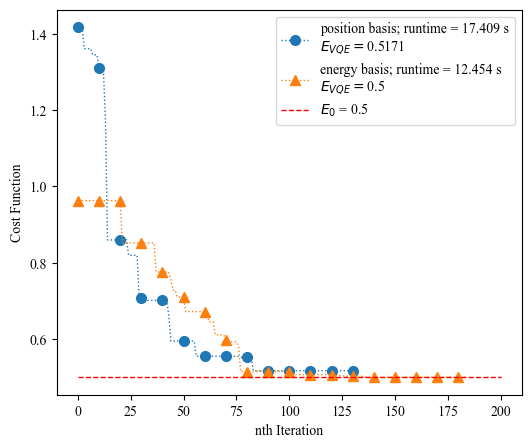

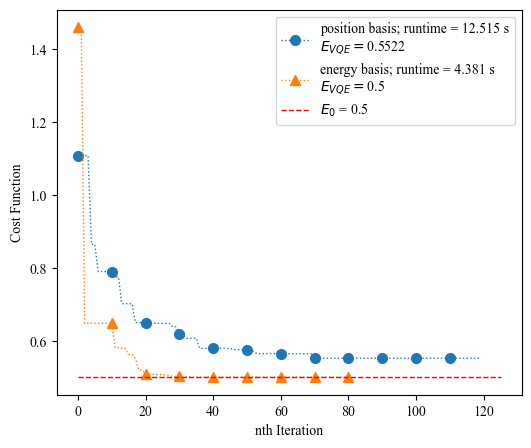

In [136]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
ax1.plot(range(0,len(toplot4posUnivfixed)),toplot4posUnivfixed,marker="o", markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax1.plot(range(0,len(toplot4enUnivfixed)),toplot4enUnivfixed, marker='^', markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax1.plot((0,200),(0.5,0.5),color='red', linewidth = 1, linestyle="dashed")
ax1.set_ylabel("Cost Function")
ax1.set_xlabel("nth Iteration")
ax1.legend(["position basis; runtime = "+str(round(toplot4posUniv[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4posUnivfixed),4)),"energy basis; runtime = "+str(round(toplot4enUniv[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4enUnivfixed),4)), r"$E_0$ = 0.5"],loc='best')

fig, ax2 = plt.subplots(1, 1, figsize=(6,5))
ax2.plot(range(0,len(toplot4posHEAfixed)),toplot4posHEAfixed,marker="o", markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax2.plot(range(0,len(toplot4enHEAfixed)),toplot4enHEAfixed,marker='^', markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax2.set_ylabel("Cost Function")
ax2.set_xlabel("nth Iteration")
ax2.plot((0,125),(0.5,0.5),color='red', linewidth = 1, linestyle="dashed")
ax2.legend(["position basis; runtime = "+str(round(toplot4posHEA[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4posHEAfixed),4)),"energy basis; runtime = "+str(round(toplot4enHEA[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot4enHEAfixed),4)), r"$E_0$ = 0.5"],loc='best')

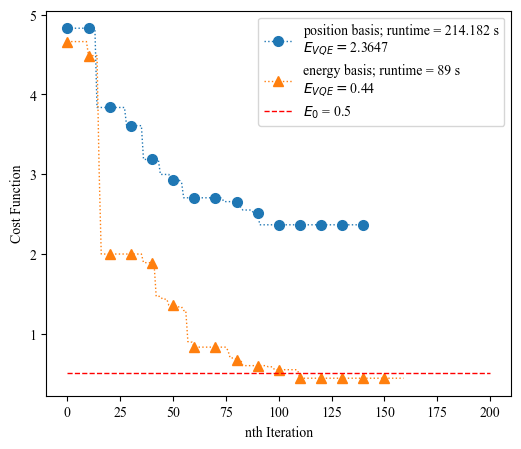

In [189]:
fig, ax3 = plt.subplots(1, 1, figsize=(6,5))
ax3.plot(range(0,len(toplot16posHEAfixed)),toplot16posHEAfixed,marker="o", markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax3.plot(range(0,len(toplot16enHEAfixed)),toplot16enHEAfixed, marker='^', markersize = 7,markevery=10, linewidth = 1, linestyle = 'dotted')
ax3.plot((0,200),(0.5,0.5),color='red', linewidth = 1, linestyle="dashed")
ax3.set_ylabel("Cost Function")
ax3.set_xlabel("nth Iteration")
ax3.legend(["position basis; runtime = "+str(round(toplot16posHEA[1],3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot16posHEAfixed),4)),"energy basis; runtime = "+str(round(round(toplot16enHEA[1]),3)) + " s\n" r"$E_{VQE} = $" + str(np.round(min(toplot16enHEAfixed),4)), r"$E_0$ = 0.5"],loc='best')

In [ ]:
from qiskit.circuit import Parameter

q = QuantumRegister(4)
c = ClassicalRegister(4)
qc = QuantumCircuit(q,c)
Four_Qubit_HEA( qc, q, [Parameter("θ"+str(i)) for i in range(16)])
qc.draw('mpl')

In [ ]:
print(low)

It should be noted that running the above code does not always settle at the exact same value (which is to be expected, since there is some randomness with how the parameters are initialized). I may have also rerun the above code and so the calculations below might not exactly match (but will more or less have similar results).

Lastly, we still need to include the weight attributed to the identity matrix in the Pauli string expansion. Hence, the calculated ground state energy for the QHO is:

$$
\braket{H}_\text{min} = -1.533158 + 1.963495 = 0.430337
$$

There are two ways we can measure the error: 1) we compare this to the lowest eigenvalue for the constructed Hamiltonian (max possible accuracy), and 2) we compare this to the actual lowest eigenvalue using the continuous analytic solution. The max possible accuracy is shown below:

In [ ]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In [ ]:
bc = ansatz.assign_parameters({phi: 3.14})
bc.measure_all()bc.draw('mpl')

Hence, the % error for the ground state energy calculated using VQE is 16% when compared to the constructed ground state energy and 13.93% when compared to the actual ground state energy. Not great, but we can probably play around with the ansatz and optimizer to see if we are able to arrive at a better approximation.

## Other References:
1. Griffiths, D. J., & Schroeter, D. F. (2018). Introduction to Quantum Mechanics (3rd ed.). Cambridge University Press. https://doi.org/10.1017/9781316995433
2. Wikipedia contributors. (2023, April 18). Diagonalizable matrix. In Wikipedia, The Free Encyclopedia. Retrieved 02:34, August 10, 2023, from https://en.wikipedia.org/w/index.php?title=Diagonalizable_matrix&oldid=1150561711
3. Wikipedia contributors. (2023, August 7). Basis (linear algebra). In Wikipedia, The Free Encyclopedia. Retrieved 04:21, August 10, 2023, from https://en.wikipedia.org/w/index.php?title=Basis_(linear_algebra)&oldid=1169174478
4. Tilly, J., Chen, H., Cao, S., Picozzi, D., Setia, K., Li, Y., Grant, E., Wossnig, L., Rungger, I., Booth, G. H., & Tennyson, J. (2022). The Variational Quantum Eigensolver: A review of methods and best practices. Physics Reports, 986, 1–128. https://doi.org/10.1016/j.physrep.2022.08.003
5. Pesce, R. M. N., & Stevenson, P. D. (2021). H2ZIXY: Pauli spin matrix decomposition of real symmetric matrices (arXiv:2111.00627). arXiv. http://arxiv.org/abs/2111.00627
6. Koch, D., Patel, S., Wessing, L., & Alsing, P. M. (2020). Fundamentals In Quantum Algorithms: A Tutorial Series Using Qiskit Continued (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2008.10647
